In [1]:
%matplotlib inline

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

z_dim = 100

# Generator


In [3]:
def generator(img_shape, z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(
                128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(
                64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(
                1, kernel_size=3, strides=2, padding='same'))

    # Tanh activation
    model.add(Activation('tanh'))

    z = Input(shape=(z_dim,))
    img = model(z)

    return Model(z, img)

# Discriminator


In [4]:
def discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(Conv2D(32, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))

    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(Conv2D(64, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))
    
    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(Conv2D(128, kernel_size=3, strides=2, 
                             input_shape=img_shape, padding='same'))
    
    # Batch normalization
    model.add(BatchNormalization())
    
    # Leaky ReLU
    model.add(LeakyReLU(alpha=0.01))

    # Flatten the tensor and apply sigmoid activation function
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    prediction = model(img)

    return Model(img, prediction)

# Build Model

In [5]:
# Build and compile the Discriminator
discriminator = discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(), metrics=['accuracy'])

# Build the Generator
generator = generator(img_shape, z_dim)

# Generated image to be used as input
z = Input(shape=(100,))
img = generator(z)

# Keep Discriminator’s parameters constant during Generator training
discriminator.trainable = False

# The Discriminator’s prediction
prediction = discriminator(img)

# Combined GAN model to train the Generator
combined = Model(z, prediction)
combined.compile(loss='binary_crossentropy', optimizer=Adam())








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Training


In [6]:
losses = []
accuracies = []

def train(iterations, batch_size, sample_interval):
    
    # Load the MNIST dataset
    #(X_train, _), (_, _) = mnist.load_data()
    
    # Load the HODA dataset
    (X_train, _), (_, _) = mnist.load_data()
    X_train = np.array(X_train)
    
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real and fake examples
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        
        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Select a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Discriminator loss
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Generator loss
        g_loss = combined.train_on_batch(z, real)

        if iteration % sample_interval == 0:
            
            # Output training progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % 
                         (iteration, d_loss[0], 100*d_loss[1], g_loss))
            
            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss[0], g_loss))
            accuracies.append(100*d_loss[1])

            # Output generated image samples 
            sample_images(iteration)

In [7]:
def sample_images(iteration, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, 
              (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale images to 0-1
    gen_imgs = 0.5 * gen_imgs + 0.5
 
    # Set image grid
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                    figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output image grid
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1

In [8]:
# Suppress warnings because the warning Keras gives us about non-trainable parameters is by design:
# The Generator trainable parameters are intentionally held constant during Discriminator training and vice versa
import warnings; warnings.simplefilter('ignore')

0 [D loss: 0.011299, acc.: 100.00%] [G loss: 0.780620]
100 [D loss: 0.013336, acc.: 100.00%] [G loss: 1.074060]
200 [D loss: 0.183574, acc.: 93.75%] [G loss: 3.455640]
300 [D loss: 0.310040, acc.: 89.45%] [G loss: 3.046954]
400 [D loss: 0.020957, acc.: 100.00%] [G loss: 4.072375]
500 [D loss: 0.058848, acc.: 98.83%] [G loss: 3.404093]
600 [D loss: 0.096995, acc.: 97.66%] [G loss: 4.314668]
700 [D loss: 0.142421, acc.: 95.70%] [G loss: 5.168090]
800 [D loss: 0.007451, acc.: 100.00%] [G loss: 3.768309]
900 [D loss: 0.162476, acc.: 94.14%] [G loss: 2.964047]


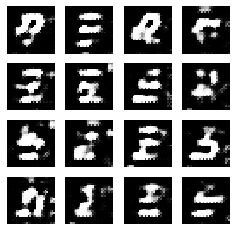

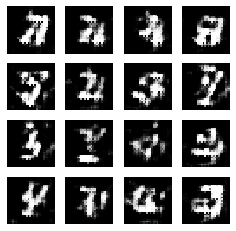

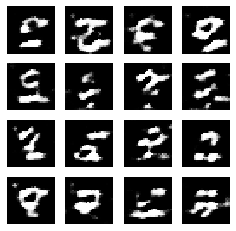

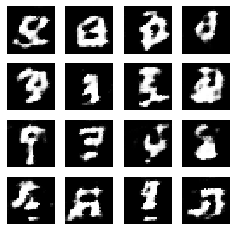

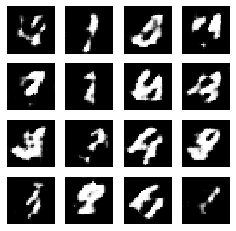

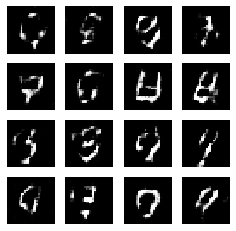

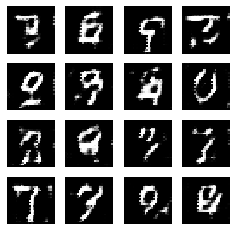

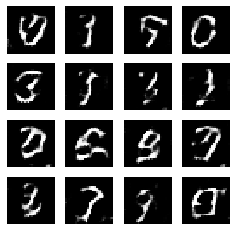

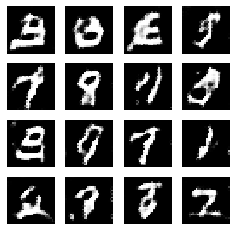

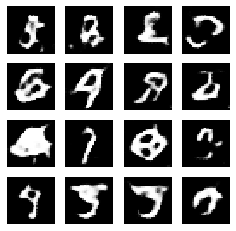

In [10]:
iterations = 1000
batch_size = 128
sample_interval = 100

# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

(60000, 28, 28)